In [136]:


import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
from scipy import optimize
import pprint


class Gaussian():
    
    def __init__(self, n=None, delta=None, alpha=None, power=None, sd=None,  two_sided=True):
        # method that initializes the instance of the Normal class
        """ n - minimal sample size for one group
        delta - effect size 
        alpha - significance level (Type I error)
        power - power of the test while 0.8 being the default  (1 minus Type II error)
        sd    - standard deviation in the control group
        tails - default two sided test 
        """
        #if is None:
         #   raise Exception("Parameter mean_control_group must be specified")  

        if sum([n is None, delta is None,alpha is None,power is None,sd is None])!=1:
            print(sum([n is None, delta is None, alpha is None, power is None, sd is None]))
            raise Exception("One and only one of the parameters n, delta, alpha, power, sd must be None")
        elif np.abs(any([alpha, power]))>1:
            raise ValueError("any of the arguments alpha, power must be within range 0-1") 
        else:
            self.delta=delta
            self.power=power
            self.alpha=alpha
            self.sd=sd
            self.two_sided = two_sided
            self.z_score_a=norm.ppf(1-self.alpha/(1 if self.two_sided==False else 2)) if alpha is not None else None
            self.z_score_b=norm.ppf(self.power) if power is not None else None
            #self.mean_test_group=self.delta if self.delta is None else self.mean_control_group + self.delta
            
            # sample size attribute will be the floor of the provided argument (integer of sample available) or the ceiling of the calculated value (based on other parameters).
            self.n=self.Sample_Size_() if n is None else np.floor(n)
            self.power=self.Power_() if self.power is None else power
            self.delta=self.Delta_() if self.delta is None else delta
            self.alpha=self.Alpha_() if self.alpha is None else alpha
            self.sd=self.SD_() if self.sd is None else sd
            self.params={'n': int(np.ceil(self.n)), 'delta': round(self.delta,4), 'alpha': round(self.alpha,4), 'power': round(self.power,4), 'sd': round(self.sd, 4), 'two-sided experiment': self.two_sided}

    #def params_(self):
         # method which returns the parameters and arguments of the class
     #    return "n: {}, delta: {}, alpha: {}, power: {}, standard deviation: {}, two-sided experiment: {}".format(self.n,  self.delta, self.alpha, self.power, self.sd, self.two_sided)
     
    def Sample_Size_(self)-> int:
         # method that returns the minimal sample size of one group given other arguments

        n=2*self.sd**2 * (self.z_score_a + self.z_score_b)**2 / (self.delta)**2
        return n
    
    def Power_(self)-> float:
        # method that returns the power of the test given other arguments

        self.z_score_b = np.sqrt((self.n * (self.delta)**2)/(2*self.sd**2)) - self.z_score_a 
        power = norm.cdf(self.z_score_b)
        return power
    
    def Alpha_(self)-> float:
        # method that returns the probability of type 1 error (p_value) of the test given other arguments

        self.z_score_a= np.sqrt((self.n * (self.delta)**2)/(2*self.sd**2)) - self.z_score_b
        alpha=self.alpha=(1-norm.cdf(self.z_score_a)) * (1 if self.two_sided==False else 2)
        return alpha

    def Delta_(self)-> float:
        # method that returns the delta of the test given other arguments

        delta = np.sqrt((2*self.sd**2 * (self.z_score_a + self.z_score_b)**2)/self.n)
        return delta
    
    def SD_(self)-> float:
        # method that returns the standard deviation of the test given other arguments

        sd = np.sqrt(self.n * (self.delta)**2/(2* (self.z_score_a + self.z_score_b)**2))
        return sd
     


class Binomial(): 

    def __init__(self, n=None, p1=None, delta=None, alpha=None, power=None, two_sided=True):
 
        # method that initializes the instance of the Binomial class
        """ n - minimal sample size for one group
        p - probability of success in control group
        delta - effect size 
        alpha - significance level (Type I error)
        power - power of the test while 0.8 being the default  (1 minus Type II error)
        tails - default two sided test 
        """

        if sum([p1 is None, n is None, delta is None, alpha is None, power is None])!=1:
            raise Exception("One and only one of the parameters n, delta, alpha, power must be None")
        elif np.abs(any([alpha, power]))>1:
            raise ValueError("any of the arguments alpha, power must be within range 0-1")
        elif delta is not None and np.abs(delta)>1:
            raise ValueError("delta must be within range 0-1") 
        else:
            self.p1=p1
            self.delta=delta
            self.power=power
            self.alpha=alpha
            self.two_sided = two_sided
            self.p2=self.p1 + self.delta if self.delta is not None and self.p1 is not None else None
            self.z_score_a=norm.ppf(1-self.alpha/(1 if self.two_sided==False else 2)) if alpha is not None else None
            self.z_score_b=norm.ppf(self.power) if power is not None else None

            # sample size attribute will be the floor of the provided argument (integer of sample available) or the ceiling of the calculated value (based on other parameters).
            self.n=self.Sample_Size() if n is None else np.floor(n)
            self.p1=self.Probability_Control() if p1 is None else p1
            self.power=self.Power() if self.power is None else power
            self.delta=self.Delta() if self.delta is None else delta
            self.alpha=self.Alpha() if self.alpha is None else alpha
            self.params={"n": int(np.ceil(self.n)), "p1": self.p1, "delta": self.delta, "alpha": self.alpha, "power": self.power, "two-sided experiment": self.two_sided}
     

    def Sample_Size(self)-> int:
         # method that returns the minimal sample size of one group given other arguments
        n=(self.z_score_a * np.sqrt((self.p1+self.p2)*(1-self.p1 + 1-self.p2)/2) + self.z_score_b*np.sqrt((self.p1*(1-self.p1)) + (self.p2 * (1-self.p2))))**2/self.delta**2

        # http://meteo.edu.vn/GiaoTrinhXS/e-book/PQ220-6234F.Ch-10.pdf
        return n
    
    def Probability_Control(self)-> float:
        # method that returns the probability of success in control group
        warnings.filterwarnings("ignore", category = RuntimeWarning)
        def func(p1):
            return (self.z_score_a * np.sqrt((2*p1+self.delta)*(1-p1 + 1-p1-self.delta)/2) + self.z_score_b*np.sqrt((p1*(1-p1)) + ((p1+self.delta) * (1-p1-self.delta))))**2/self.delta**2 - self.n
        p1=round(optimize.bisect(func, a=0, b=1), 2)
        warnings.filterwarnings("always", category = RuntimeWarning)
        return p1

    def Power(self)-> float:
        # method that returns the power of the test given other arguments
        self.z_score_b=(np.sqrt(self.n * self.delta**2) - self.z_score_a * np.sqrt((self.p1+self.p2)*(1-self.p1 + 1-self.p2)/2))* 1/np.sqrt((self.p1*(1-self.p1)) + (self.p2 * (1-self.p2))) 
        power=norm.cdf(self.z_score_b)
        return power
    
    def Alpha(self)-> float:
        # method that returns the probability of type 1 error (p_value) of the test given other arguments
        self.z_score_a=(np.sqrt(self.n * self.delta**2)-self.z_score_b*np.sqrt((self.p1*(1-self.p1)) + (self.p2 * (1-self.p2))))/np.sqrt((self.p1+self.p2)*(1-self.p1 + 1-self.p2)/2) 
        alpha=self.alpha=(1-norm.cdf(self.z_score_a)) * (1 if self.two_sided==False else 2)
        return alpha

    def Delta(self)-> float:
        # method that returns the delta of the test given other arguments
        warnings.filterwarnings("ignore", category = RuntimeWarning)
        def func(delta):
            return (self.z_score_a * np.sqrt((2*self.p1+delta)*(1-self.p1 + 1-self.p1-delta)/2) + self.z_score_b*np.sqrt((self.p1*(1-self.p1)) + ((self.p1+delta) * (1-self.p1-delta))))**2/delta**2 - self.n
        delta=round(optimize.bisect(func, a=0, b=1), 4)
        warnings.filterwarnings("always", category = RuntimeWarning)
        return delta


class ab_testing(Binomial,Gaussian):

    def __init__(self, data=None, metric=None, distribution=None ,date_column=None, experiment_unit_column=None, n=None, p1=None, delta=None, alpha=None, power=None, sd=None ,two_sided=True, num_comparisons=1):
        
        self.data=data
        self.num_comparisons=num_comparisons
        alpha=alpha/self.num_comparisons if alpha is not None else None
        
        if distribution in ["Binomial", "Gaussian", "Normal"]:
            self.distribution=distribution
        else: 
            raise ValueError('Distribution must be "Binomial" , "Gaussian" or "Normal"')
        if data is not None:
            
            self.metric=metric
            self.date_column=date_column
            self.experiment_unit_column=experiment_unit_column
            if distribution=='Binomial':
                self.p1=self.data[self.metric].mean()
            else:
                self.sd=np.std(self.data[self.metric].values, ddof=1)
                
            self.alpha=alpha
            self.power=power
            self.two_sided=two_sided
            self.delta=delta
            
        else:
            if distribution=='Binomial':
                Binomial.__init__(self, n, p1, delta, alpha, power, two_sided)
            elif distribution in ('Normal','Gaussian'):
                Gaussian.__init__(self, n, delta, alpha, power, sd,  two_sided)

    def __str__(self):
        # method which returns the parameters and arguments of the ab-testing instance
         if self.data is None:
            self.params['distribution']=self.distribution
            if self.num_comparisons>2:
                self.params['number of comparisons']=self.num_comparisons
                self.params['alpha']=self.alpha*self.num_comparisons
                self.params['correction']='Bonferroni correction to family wise alpha was applied for every pairwise comparison'
            return pprint.pformat(width=100, object=self.params, sort_dicts=False)
         else:
            self.params={'alpha':self.alpha*self.num_comparisons, 'power':self.power, 'two-sided experiment': self.two_sided}
            return pprint.pformat(width=100, object=self.params, sort_dicts=False)
         
         

# method which returns the Minimal Detectable Effect experiment time estimation for an array of effect values.

    def MDE(self, events_per_time_unit_and_variant=None ,minimal_effect=None, maximal_effect=None, effect_step=None, two_sided=True, plot=False, save_path=None, **plot_kwargs):
        # produces an array of delta values
        if not all([minimal_effect,maximal_effect,effect_step]):
            raise ValueError('The values of minimal_effect, maximal_effect, effect_step cannot be None')
        #array of effect size values
        effect_magnitudes=np.arange(minimal_effect,maximal_effect + effect_step ,effect_step)
        #list of experiment days needed for corresponding effect
        days=[]
        sizes=[]

        if self.data is not None:

            #calculates number of time units present in the dataset
            length_input_data = self.data[self.date_column].nunique()
            #calculates the floor of events per time unit
            self.events_per_time_unit_and_variant=np.floor(len(self.data[(self.data)[self.metric].notnull()])/length_input_data/(self.num_comparisons+1))
            #the metric of interest base value
            pre_experiment_value=self.data[self.metric].mean()
            
        else:
            if events_per_time_unit_and_variant is None:
                raise ValueError('if data with temporal dimension is not provided, number of events per time unit and variant must be specified')
                
            else:
                self.events_per_time_unit_and_variant=events_per_time_unit_and_variant
            
        
        for i in effect_magnitudes:
            self.delta=i
            
            if self.distribution in ('Binomial'):
                
                self.p1=self.p1 if self.p1 is not None else pre_experiment_value
                self.p2=self.p1 + self.delta
                Binomial.__init__(self, n=None , p1=self.p1 , delta=self.delta, alpha=self.alpha/self.num_comparisons , power=self.power, two_sided=self.two_sided)
                n=self.n
            else:
                Gaussian.__init__(self, n=None , sd=self.sd , delta=self.delta, alpha=self.alpha/self.num_comparisons, power=self.power, two_sided=self.two_sided)
                n=self.n
            sizes.append(int(np.ceil(n)))
            days.append(int(np.ceil(n/self.events_per_time_unit_and_variant)))

        results=pd.DataFrame({'effect':effect_magnitudes,'sample size per group':sizes ,'length of experiment':days})
        self.delta=effect_magnitudes
        self.n=sizes
        self.experiment_length=days
        
        if not plot: 
            self.mde=results
            return self.mde
        else: 
            self.mde=self.Plot_MDE(save_path, results, **plot_kwargs)
            return self.mde
    
    def Plot_MDE(self, save_path=None ,results=None, figsize=(10,5), title='MDE', marker='o', ls='-',annot=True, **plot_kwargs):

        fig=plt.figure(figsize=figsize)
        ax=plt.axes()
        ax.grid(visible=True, linewidth=2)
        ax.set_title(title)
        ax.set_xlabel('Length of Experiment')
        ax.set_ylabel(u'Effect Δ')
        ax.plot(results['length of experiment'].values, results['effect'].values, marker=marker, ls=ls, **plot_kwargs)
        if annot==True:
            for i in range(len(results)):
                plt.annotate(xy=(results['length of experiment'].values[i]+np.min([25,results['length of experiment'].min()]), results['effect'].values[i]), text=results['length of experiment'].values[i])
                
        ax.set_xlim(-1*(results['length of experiment'].max()*1.05-results['length of experiment'].max()), results['length of experiment'].values[i]+results['length of experiment'].max()*1.05)
        fig=ax.figure
        if save_path is not None:
            fig.savefig(save_path)
        else:
            plt.close()
            return fig
    
    def clustered_power(self, cluster_col: str , num_variants: int=None , delta=None, iterations: int=200, verbose=True):
        import statsmodels.api as sm
         
        family = sm.families.Gaussian()
        cov_struct=sm.cov_struct.Exchangeable()

        def allocate_treatment(data, cluster_col, num_variants):   
            clusters=data[cluster_col].unique()
            treatments=[np.random.choice(num_variants,1)[0] for i in clusters]
            clusters=pd.DataFrame({'clusters':clusters, 'treatments':treatments})
            clusters=pd.get_dummies(clusters, columns=['treatments'], drop_first=True)
            data=data.merge(clusters, how='left', left_on=cluster_col, right_on='clusters')
            data=data.drop('clusters', axis=1)
            return data
        def add_effect(data, delta):
            data[self.metric]=np.where(data.iloc[:,2]==1, data[self.metric]+delta, data[self.metric])
            return data
        num_significant=0
        n=1
        alpha=self.alpha*self.num_comparisons
        delta=delta if delta is not None else self.delta
        if delta is None:
            raise ValueError('Delta must be specified when instantiating the class or when calling the method')
        for i in range(iterations):
            data=self.data[[cluster_col, self.metric]].copy()
            num_variants=num_variants if num_variants is not None else self.num_comparisons+1
            data=add_effect(allocate_treatment(data, cluster_col, num_variants), delta)
            model=sm.GEE.from_formula(f'{self.metric} ~ {" + ".join(data.iloc[:,2:].columns)}', data=data, groups=cluster_col , family=family, cov_struct=cov_struct)
            result=model.fit()
            num_significant+=result.pvalues[1]<alpha
            if verbose:
                print(f'Iteration {n}')
            n+=1

        print(f'The power of the test is {num_significant/iterations}')


In [2]:
#Obteniendo la deviación estandar

Gaussian(n=14128, delta=0.02, alpha=0.05 ,power=0.8, two_sided=True).params


{'n': 14128,
 'delta': 0.02,
 'alpha': 0.05,
 'power': 0.8,
 'sd': 0.6,
 'two-sided experiment': True}

In [3]:
#obteniendo alpha (nivel de significado del test)

Gaussian(n=14128, delta=0.02 ,power=0.8, sd=0.6, two_sided=True).params

{'n': 14128,
 'delta': 0.02,
 'alpha': 0.05,
 'power': 0.8,
 'sd': 0.6,
 'two-sided experiment': True}

In [4]:
#obteniendo power (potencia del test)

Gaussian(n=14128, delta=0.02,  alpha=0.05 ,sd=0.6, two_sided=True).params

{'n': 14128,
 'delta': 0.02,
 'alpha': 0.05,
 'power': 0.8,
 'sd': 0.6,
 'two-sided experiment': True}

In [5]:
Gaussian(n=14128, alpha=0.05, power=0.8, sd=0.6 ,two_sided=True).params

{'n': 14128,
 'delta': 0.02,
 'alpha': 0.05,
 'power': 0.8,
 'sd': 0.6,
 'two-sided experiment': True}

In [6]:
#Usage of Binomial class:

Binomial(p1=0.2, delta=0.01, alpha=0.05, power=0.8).params

{'n': 25583,
 'p1': 0.2,
 'delta': 0.01,
 'alpha': 0.05,
 'power': 0.8,
 'two-sided experiment': True}

In [7]:
#instantiating the ab_testing class object:

a=Binomial(n=25883, p1=0.2, delta=0.01, alpha=0.05)

a.power

0.8045654450900508

## Minimum Detectable Effect (*MDE*)

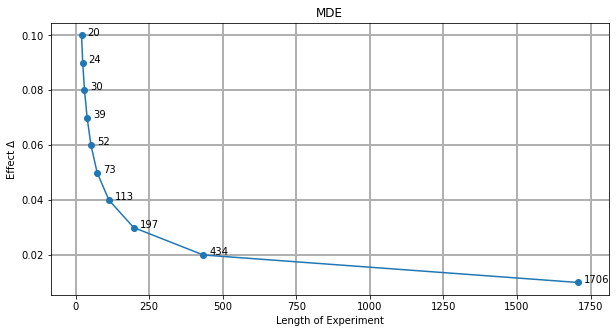

In [8]:
ab_testing(n=25583, p1=0.2, alpha=0.05, power=0.8, two_sided=True, distribution='Binomial').MDE(minimal_effect=0.01, maximal_effect=0.1, effect_step=0.01, events_per_time_unit_and_variant=15, plot=True)

In [9]:
experiment=ab_testing(p1=0.2, n=25583, alpha=0.05, power=0.8 ,two_sided=True, distribution='Binomial')

experiment.MDE(minimal_effect=0.01, maximal_effect=0.1, effect_step=0.01, events_per_time_unit_and_variant=60)

,effect,sample size per group,length of experiment
0,0.01,25583,427
1,0.02,6510,109
2,0.03,2943,50
3,0.04,1683,29
4,0.05,1094,19
5,0.06,772,13
6,0.07,575,10
7,0.08,447,8
8,0.09,358,6
9,0.10,294,5


In [10]:
cats=pd.read_csv('C:/Users/gshoc/OneDrive/Documentos/MASTER/TFM/Cookie Cats/cookie_cats.csv')

In [11]:
cats.head(6)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True


In [12]:
cats[['retention_1','retention_7']]=np.where(cats[['retention_1','retention_7']]==True, 1,0)

In [13]:
cats=cats[cats.version=='gate_30'].drop('version', axis=1)

In [14]:
startdate=datetime.date(year=2023,month=5,day=1)

cats['day']=[startdate+datetime.timedelta(np.random.randint(1,31)) for i in range(len(cats))]



In [15]:
cats.head(6)

,userid,sum_gamerounds,retention_1,retention_7,day
0,116,3,0,0,2023-05-28
1,337,38,1,0,2023-05-28
6,1066,0,0,0,2023-05-27
11,2101,0,0,0,2023-05-04
13,2179,39,1,0,2023-05-07
14,2218,305,1,1,2023-05-17


In [16]:
ab_testing(data=cats, distribution='Binomial', date_column='day', experiment_unit_column='userid', metric='retention_1', alpha=0.05, power=0.8, two_sided=True).MDE(minimal_effect=0.01, maximal_effect=0.1, effect_step=0.01) 

,effect,sample size per group,length of experiment
0,0.01,38900,53
1,0.02,9742,14
2,0.03,4336,6
3,0.04,2442,4
4,0.05,1565,3
5,0.06,1087,2
6,0.07,799,2
7,0.08,612,1
8,0.09,484,1
9,0.10,392,1


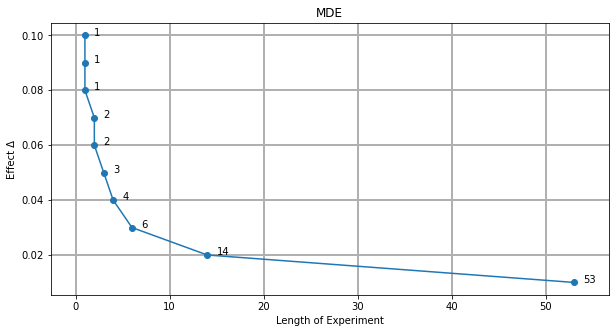

In [17]:
experiment=ab_testing(data=cats, distribution='Binomial', date_column='day', metric='retention_1', 
                      alpha=0.05, power=0.8, two_sided=True, num_comparisons=1)

experiment.MDE(minimal_effect=0.01, maximal_effect=0.1, effect_step=0.01, plot=True, annot=True) 

In [18]:
print(ab_testing(data=cats, distribution='Binomial', date_column='day', metric='retention_1', 
                      alpha=0.05, power=0.8, two_sided=True, delta=0.01))

{'alpha': 0.05, 'power': 0.8, 'two-sided experiment': True}


In [19]:
print(ab_testing(delta=0.01, p1=0.2, alpha=0.05, power=0.8, two_sided=True, distribution='Binomial', num_comparisons=4))

{'n': 36346,
 'p1': 0.2,
 'delta': 0.01,
 'alpha': 0.05,
 'power': 0.8,
 'two-sided experiment': True,
 'distribution': 'Binomial',
 'number of comparisons': 4,
 'correction': 'Bonferroni correction to family wise alpha was applied for every pairwise '
               'comparison'}


# Clustered Experiments

In [20]:
# Creating an imaginary dataset

np.random.seed=0

x=np.random.dirichlet(alpha=np.random.gamma(3, 2, 1000))

driver_id=np.random.choice(np.arange(1000), 100000, replace=True, p=x)

df=pd.DataFrame({'driver_id':driver_id})
df['weekday']=np.random.choice(np.arange(7), size=100000)
df['reaction_time']=df.apply(lambda x: x.driver_id/1000 * x.weekday + np.random.rand() , axis=1)

In [21]:
df.head()

,driver_id,weekday,reaction_time
0,436,6,3.263865
1,115,3,1.209163
2,178,5,1.849576
3,696,2,2.106905
4,191,0,0.437894


Text(0.5, 0, 'minutes')

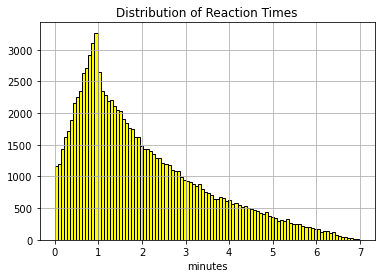

In [22]:
df.reaction_time.hist(bins=100, edgecolor='black' ,color='yellow')
plt.title('Distribution of Reaction Times')
plt.xlabel('minutes')

In [23]:
from scipy.stats import ttest_ind

def allocate_treatment(data: pd.DataFrame , user_column: str):
    data['variant']=data.groupby([user_column])[user_column].transform(lambda x: np.random.choice(['A','B']))
    return data

iterations=1000
number_significant=0
pvalues=[]


for i in range(iterations):
    df=allocate_treatment(df, 'driver_id')
    p_value=ttest_ind(df[df.variant=='A'].reaction_time , df[df.variant=='B'].reaction_time)[1]
    pvalues.append(p_value)
    number_significant+=p_value<0.05
    

print(f'False Positive Rate (Type I error): {number_significant/iterations}')
   

False Positive Rate (Type I error): 0.777


Text(0.5, 0, 'rides')

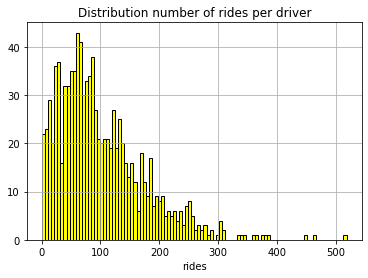

In [24]:

#distribution of number of rides per driver

df.groupby('driver_id').size().hist(bins=100, edgecolor='black' ,color='yellow')
plt.title('Distribution number of rides per driver')
plt.xlabel('rides')

In [25]:
df.driver_id.nunique()

994

In [104]:
def clustered_power(df, cluster_cols: str , metric_col: str , num_variants: int  , effect: float, alpha: float, iterations: int, verbose=True):
    import statsmodels.api as sm
    
    
    family = sm.families.Gaussian()
    cov_struct=sm.cov_struct.Exchangeable()
    
    def allocate_treatment(df, cluster_cols, metric_col, num_variants):
        clusters=df[cluster_cols].unique()
        treatments=[np.random.choice(num_variants,1)[0] for i in clusters]
        clusters=pd.DataFrame({'clusters':clusters, 'treatments':treatments})
        clusters=pd.get_dummies(clusters, columns=['treatments'], drop_first=True)
        df=df.merge(clusters, how='left', left_on=cluster_cols, right_on='clusters')
        df=df.drop('clusters', axis=1)
        return df
    def add_effect(data,effect):
        data[metric_col]=np.where(data.iloc[:,2]==1, data[metric_col]+effect, data[metric_col])
        return data
    num_significant=0
    n=1
    for i in range(iterations):
        data=df[[cluster_cols, metric_col]].copy()
        
        data=add_effect(allocate_treatment(data, cluster_cols, metric_col, num_variants)   , effect)
        model=sm.GEE.from_formula(f'{metric_col} ~ {" + ".join(data.iloc[:,2:].columns)}', data=data, groups=cluster_cols , family=family, cov_struct=cov_struct)
        result=model.fit()
        num_significant+=result.pvalues[1]<alpha
        if verbose:
            print(f'Iteration {n}')
        n+=1

    return num_significant/iterations


In [101]:
clustered_power(df, cluster_cols='driver_id' , metric_col='reaction_time' , num_variants=3  , effect=0.02, alpha=0.05, iterations=400, verbose=False)

0.055

In [120]:
experiment=ab_testing(p1=0.25, n=8500, alpha=0.05, power=0.8 ,two_sided=True, distribution='Binomial', num_comparisons=3)

#experiment.MDE(minimal_effect=0.01, maximal_effect=0.1, effect_step=0.01, events_per_time_unit_and_variant=60)

In [162]:
experiment=ab_testing(data=df, metric='reaction_time' , num_comparisons=2  , alpha=0.05, distribution='Gaussian')

In [166]:
experiment.clustered_power(cluster_col='driver_id', iterations=400, verbose=False, num_variants=3, delta=0.0)

The power of the test is 0.03


In [40]:
print(experiment)

{'n': 8500,
 'p1': 0.25,
 'delta': 0.0218,
 'alpha': 0.05,
 'power': 0.8,
 'two-sided experiment': True,
 'distribution': 'Binomial',
 'number of comparisons': 3,
 'correction': 'Bonferroni correction to family wise alpha was applied for every pairwise '
               'comparison'}


In [ ]:
df.groupby('variant').reaction_time.mean().diff()

In [ ]:
import statsmodels.api as sm
    
    
family = sm.families.Gaussian()
cov_struct=sm.cov_struct.Exchangeable()
#df['variant']=np.where(df.variant=='A',1,0)
model=sm.GEE.from_formula(f'{"reaction_time"} ~ {" + ".join(df.iloc[:,3:].columns)}', data=df, groups='driver_id' , family=family, cov_struct=cov_struct)
result=model.fit()

In [ ]:
result.summary()

In [ ]:
cats['retention_1']=np.where(cats.retention_1==True, 1,0)

In [ ]:
def gst(data, metric_col=None, proportion_sample_sizes=[0.2,0.4,0.6,0.8,1] , alpha=0.05, method='obf'):
    sample=data[metric_col].values
    sample_size=len(sample)
    zeds=[]
    
    def alpha_spending(t,alpha, method):
        if method=='obf':
            a=2-2*norm.cdf(norm.cdf(1-alpha/2)**-1/np.sqrt(t))
        elif method=='pocock':
            a=alpha/2*np.log(1+(np.exp(1)-1)**t)
        else:
            a=alpha/2*t
        return a
    
    for n,t in enumerate(proportion_sample_sizes[:]):
        #z=np.sum([np.sqrt(proportion_sample_sizes[m+1]-proportion_sample_sizes[m]) * norm.ppf(alpha_spending(proportion_sample_sizes[n+1],alpha,method)) for m,i in enumerate(proportion_sample_sizes[:n-1])])/np.sqrt(np.sum([proportion_sample_sizes[m+1]-proportion_sample_sizes[m] for m,i in enumerate(proportion_sample_sizes[:n-1])]))
        #z=norm.ppf(alpha_spending(t,alpha,method))/np.sqrt(t)
        z=np.sqrt(t)*norm.ppf(alpha_spending(t,alpha,method))/np.sqrt(t-)
        zeds.append(z)
    return zeds
    

In [ ]:
norm.ppf(alpha_spending(i,0.05,'obf'))

In [ ]:
gst(data=cats, metric_col='retention_1', alpha=0.05, method='obf')

In [139]:
def alpha_spending(t, alpha, method, tails):
    """
    Implementing Lan-DeMets sequential boundaries based on approximation of O'Brian-Fleming and Pocock GST functions.  
    
    t: proportion of data seen until the moment of peeking, in comparison to total expected data 
    alpha: type 1 rate
    method: alpha spending method 
    tails: one or two-sided experiment
    """
    if method=='obf':
        a=2-2*norm.cdf(norm.ppf(1-(alpha/(2*tails)))/np.sqrt(t))
    elif method=='pocock':
        a=alpha/tails * np.log(1+(np.exp(1)-1)*t)
    elif method=='uniform':
        a= alpha/tails * t
    boundaries=[norm.ppf(a) , norm.ppf(1-a)]
    a=a*tails
    
    return {'alpha': a, 'upper boundary': np.max(boundaries) , 'lower boundary': np.min(boundaries)}

In [155]:
alpha_spending(t=0.4, alpha=0.025, method='obf', tails=2)

{'alpha': 0.00015681311367909956,
 'upper boundary': 3.780024204514791,
 'lower boundary': -3.780024204514791}

<Axes: >

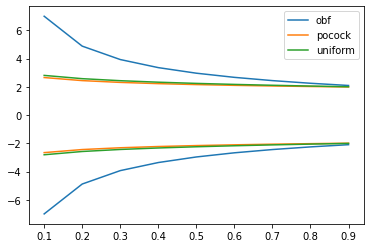

In [159]:
bound=pd.DataFrame()
n=0
for i in np.arange(0.1, 1, 0.1):
    for j in ['obf','pocock','uniform']:
        result=alpha_spending(t=i, alpha=0.05, method=j, tails=2)
        result['proportion']=i
        result['method']=j
        result=pd.DataFrame(result, index=[n])
        n+=1
        bound=pd.concat([bound, result])
        
import seaborn as sns
sns.lineplot(data=bound, x=bound['proportion'].values, y=bound['upper boundary'].values, hue=bound['method'].values)
sns.lineplot(data=bound, x=bound['proportion'].values, y=bound['lower boundary'].values, hue=bound['method'].values, legend=False)



In [160]:
bound[(bound.method=='pocock')].alpha.sum()/2

0.13276822499696428

In [161]:
bound

,alpha,upper boundary,lower boundary,proportion,method
0,2.722711e-12,6.991341,-6.991341,0.1,obf
1,7.928254e-03,2.655110,-2.655110,0.1,pocock
2,5.000000e-03,2.807034,-2.807034,0.1,uniform
3,1.077743e-06,4.876885,-4.876885,0.2,obf
4,1.476973e-02,2.437977,-2.437977,0.2,pocock
5,1.000000e-02,2.575829,-2.575829,0.2,uniform
6,8.545157e-05,3.928573,-3.928573,0.3,obf
7,2.078676e-02,2.311835,-2.311835,0.3,pocock
8,1.500000e-02,2.432379,-2.432379,0.3,uniform
9,7.883035e-04,3.356869,-3.356869,0.4,obf
